Paper: https://academic.oup.com/nsr/article/8/4/nwaa179/5896967  
All data: https://ngdc.cncb.ac.cn/gsa/browse/CRA002680   
Data used: https://ngdc.cncb.ac.cn/gsa/browse/CRA002680/CRR138429

___

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [4]:
import gget
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

#Custom plotting functions
import funcs

24 Apr 2022 13:36:10 INFO Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
24 Apr 2022 13:36:10 INFO NumExpr defaulting to 8 threads.
24 Apr 2022 13:36:10 INFO dirname: Trying to get version of get_version from dirname /home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages
24 Apr 2022 13:36:10 INFO dirname: Failed; Does not match re.compile('get[_-]version-([\\d.]+?)(?:\\.dev(\\d+))?(?:[_+-]([0-9a-zA-Z.]+))?$')
24 Apr 2022 13:36:10 INFO git: Trying to get version from git in directory /home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages
24 Apr 2022 13:36:10 INFO git: Failed; directory is not managed by git
24 Apr 2022 13:36:10 INFO metadata: Trying to get version for get_version in dir /home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages
24 Apr 2022 13:36:10 INFO metadata: Succeeded
24 Apr 2022 13:36:10 INFO dirname: Trying to get version of legacy_api_wrap from dirname /home/lauraluebbert/bin/miniconda3/lib/py

___

### Code to process from raw data

Download raw data:

In [1]:
# !cd data && wget ftp://download.big.ac.cn/gsa/CRA002680/CRR138429/CRR138429_f1.fastq.gz
# !cd data && wget ftp://download.big.ac.cn/gsa/CRA002680/CRR138429/CRR138429_r2.fastq.gz

/bin/sh: 1: cd: can't cd to data


Pipe `gget` into [`kb_python`](https://www.kallistobus.tools/) to build an index using the latest reference genome from Ensembl:

In [6]:
# !kb ref -i reference/index.idx -g reference/t2g.txt -f1 reference/fasta.fa $(gget ref -s macaca_mulatta --which dna,gtf --ftp)

Pseudoalignment and counting using [`kb_python`](https://www.kallistobus.tools/):

In [7]:
# !kb count --filter bustools \
# -i reference/index.idx \
# -g reference/t2g.txt \
# -x 10xv2 \
# --h5ad -t 8 -o "kb_CRR138429" \
# data/CRR138429_f1.fastq.gz \
# data/CRR138429_r2.fastq.gz

Split data for storage on Github:

In [2]:
# # Split file into smaller ones
# !split data/counts_unfiltered/adata.h5ad -b 100m
# # Remove original file
# !rm data/counts_unfiltered/adata.h5ad

___
# Fetch information about the reference genome

Search for "macaca" reference genomes in the latest Ensembl release.

In [4]:
!gget ref -l | grep macaca

22 Apr 2022 16:52:55 INFO Fetching available genomes in Ensembl release 106 (latest).
macaca_mulatta
macaca_nemestrina
macaca_fascicularis


There are 3 genomes available: macaca_mulatta, macaca_nemestrina and macaca_fascicularis. The data we are using here comes from *Macaca mulatta*. Let's take a look athe

In [5]:
# Info on the latest reference genome
!gget ref -s macaca_mulatta

22 Apr 2022 16:53:00 INFO Fetching reference information for macaca_mulatta from Ensembl release: 106.
{
    "macaca_mulatta": {
        "transcriptome_cdna": {
            "ftp": "http://ftp.ensembl.org/pub/release-106/fasta/macaca_mulatta/cdna/Macaca_mulatta.Mmul_10.cdna.all.fa.gz",
            "ensembl_release": 106,
            "release_date": "28-Feb-2022",
            "release_time": "16:56",
            "bytes": "31197949"
        },
        "genome_dna": {
            "ftp": "http://ftp.ensembl.org/pub/release-106/fasta/macaca_mulatta/dna/Macaca_mulatta.Mmul_10.dna.toplevel.fa.gz",
            "ensembl_release": 106,
            "release_date": "21-Feb-2022",
            "release_time": "10:31",
            "bytes": "872921950"
        },
        "annotation_gtf": {
            "ftp": "http://ftp.ensembl.org/pub/release-106/gtf/macaca_mulatta/Macaca_mulatta.Mmul_10.106.gtf.gz",
            "ensembl_release": 106,
            "release_date": "01-Mar-2022",
            "release_t

___

### Load the data

In [ ]:
# Concatenate the files in the counts_unfiltered folder into a single h5ad file
!cd data/counts_unfiltered/ && cat $(ls) > adata.h5ad

In [5]:
adata = anndata.read("data/counts_unfiltered/adata.h5ad")
adata

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/counts_unfiltered/adata.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Create new index consisting of gene_name and gene_id separated by "_" (previous index was just gene_id)
adata.var["gene_id"] = adata.var.index.values
adata.var.index = adata.var.gene_name.astype(str) + "_" + adata.var.gene_id.astype(str)
del adata.var["gene_id"]

___

# Basic quality control

In [10]:
# Expected number of cells
expected_num_cells = 10000

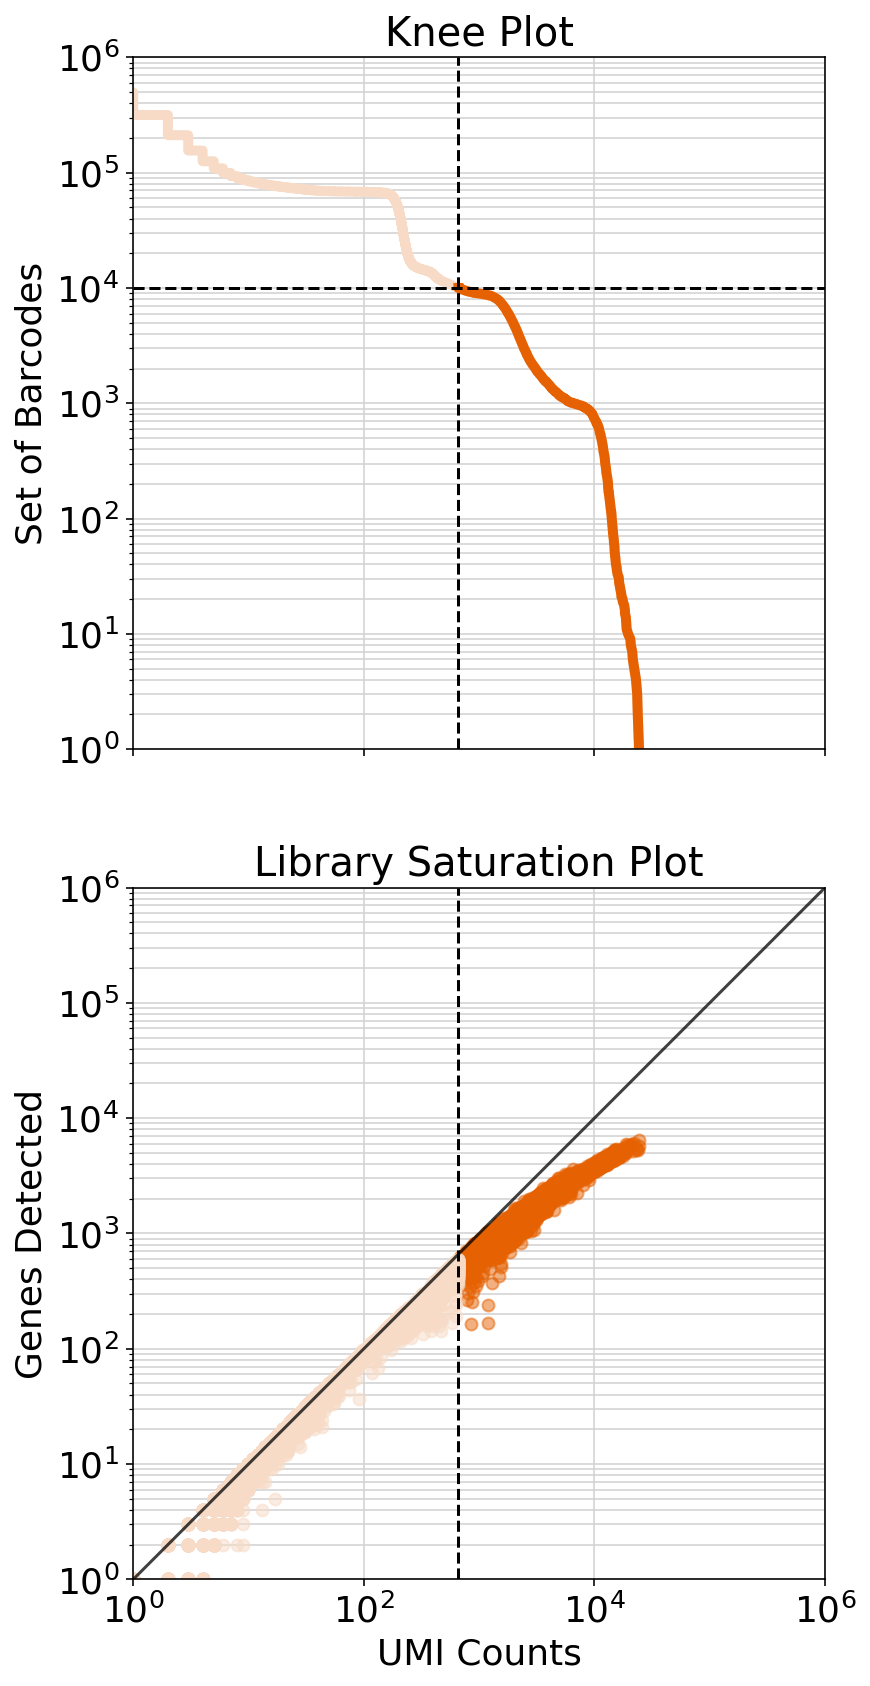

In [11]:
funcs.knee_library_sat_plot(adata, expected_num_cells)

# Find genes indicative to data quality 

Find genes in the data that are labeled as mitochondrial with start "MT-":

In [12]:
adata_mt = adata.var[adata.var.gene_name.str.startswith("MT-")]
adata_mt

,gene_name


Check whether this is a problem with the dataset/reference of the general species annotation:

In [13]:
gget.search("MT-", "macaca_m")

22 Apr 2022 16:53:33 INFO Fetching results from database: macaca_mulatta_core_106_10
22 Apr 2022 16:53:35 INFO Query time: 2.55 seconds
22 Apr 2022 16:53:35 INFO Matches found: 0


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url


It seems like there is no mitochondrial genome available for macaque. Find stress-related genes based on name and description that we could use for quality control:

In [14]:
qc_df = gget.search(["apoptosis", "inducing"], "macaca_m", andor="and")
qc_df

22 Apr 2022 16:53:36 INFO Fetching results from database: macaca_mulatta_core_106_10
22 Apr 2022 16:53:38 INFO Query time: 2.67 seconds
22 Apr 2022 16:53:38 INFO Matches found: 6


,ensembl_id,gene_name,ensembl_description,ext_ref_description,biotype,url
0,ENSMMUG00000004685,NAIF1,nuclear apoptosis inducing factor 1 [Source:VG...,nuclear apoptosis inducing factor 1,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
1,ENSMMUG00000004954,AIFM1,apoptosis inducing factor mitochondria associa...,apoptosis inducing factor mitochondria associa...,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
2,ENSMMUG00000006392,AIFM2,apoptosis inducing factor mitochondria associa...,apoptosis inducing factor mitochondria associa...,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
3,ENSMMUG00000020478,AIFM3,apoptosis inducing factor mitochondria associa...,apoptosis inducing factor mitochondria associa...,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
4,ENSMMUG00000044552,BLCAP,BLCAP apoptosis inducing factor [Source:VGNC S...,BLCAP apoptosis inducing factor,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...
5,ENSMMUG00000052518,SIVA1,SIVA1 apoptosis inducing factor [Source:HGNC S...,SIVA1 apoptosis inducing factor,protein_coding,https://uswest.ensembl.org/macaca_mulatta/Gene...


### Check expression of these genes

Find these IDs in our dataset:

In [15]:
qc_genes = funcs.find_ids(adata, qc_df["ensembl_id"].values)

Overlay with library saturation plot:

Maximum total UMI count for all apoptosis/stress genes in one cell: 13.0.


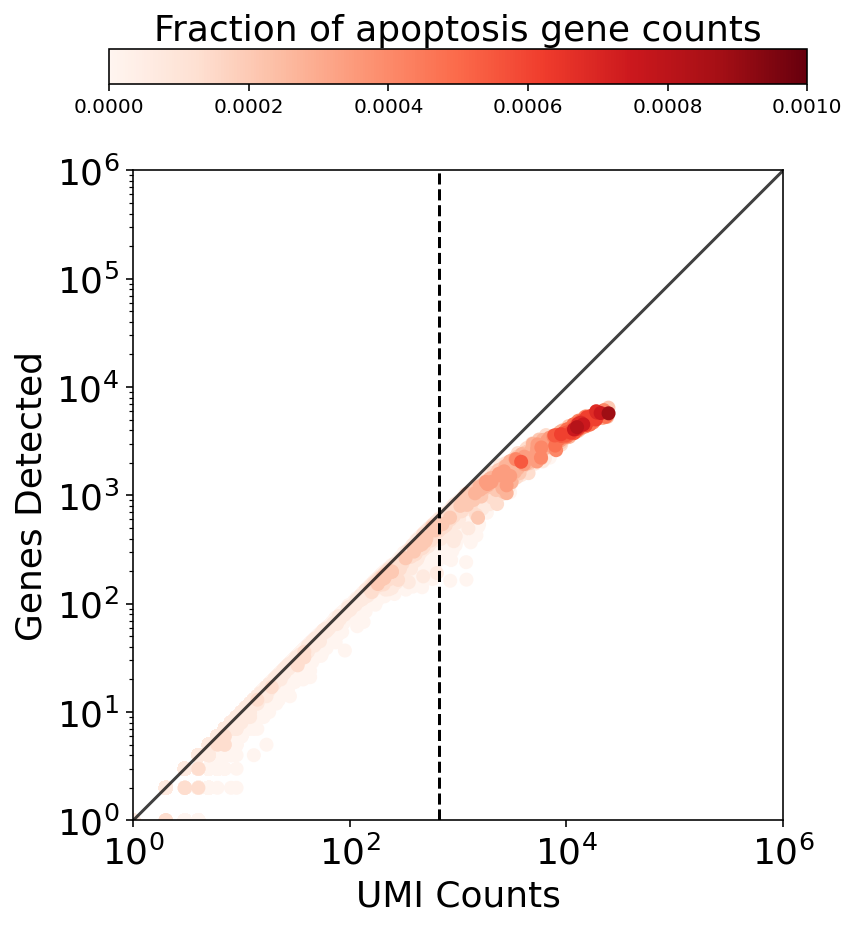

In [16]:
funcs.library_sat_gene_fraction(adata, qc_genes, gene_type="apoptosis", expected_num_cells=expected_num_cells)

Filter cells based on minimum number of UMI counts from knee plot:

In [17]:
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells]
print("The minimum number of UMI counts based on the knee plot is: " + str(min_umi))

# Removes cells with less than min_umi umi counts
adata = adata[np.asarray(adata.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata.obs['n_counts_processed'] = adata.X.sum(axis=1)

print(adata)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot is: 660.0
AnnData object with n_obs × n_vars = 9991 × 35432
    obs: 'n_counts_processed'
    var: 'gene_name'


In [18]:
# Create copy of raw count (after basic filtering)
adata.raw = adata.copy()

___

#### Normalization

Show highest expressing genes before normalization:

In [19]:
# sc.pl.highest_expr_genes(adata, n_top=20)

Divide each gene count by the total # of UMI's for that cell. Then take log(X+1) (+1 because you cannot take log(0)) (=log transformation). Note: Doing CP10k instead of CPM because Leiden clustering gives ~50 clusters if I use CPM for some unkown reason.

In [20]:
# CP10k normalization
sc.pp.normalize_total(adata, target_sum=10**4) 
# log(expression + 1)
sc.pp.log1p(adata) # log(expression + 1)

Highest expressed genes after normalization and log:

In [21]:
# sc.pl.highest_expr_genes(adata, n_top=20)

Annotate highly variable genes:

In [22]:
sc.pp.highly_variable_genes(adata)
# sc.pl.highly_variable_genes(adata)

___

#### Clustering

In [23]:
# Define number of nearest neighbours
n_neighbors = 20
n_pcs=10

In [24]:
# Perform PCA on just the highly variable genes
sc.tl.pca(adata, use_highly_variable=True)

In [25]:
# Find nearest neighbors
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=0)

# Leiden clustering on the neighboorhood graph
sc.tl.leiden(adata, random_state=0)

____

In [26]:
# adata.write("macaque_norm_clustered.h5ad")